# **Data Understanding**

In [1]:
# Install library ultralytics (YOLOv8)
!pip install ultralytics

# Library tambahan yang mungkin diperlukan, pastikan semua terinstal
!pip install opencv-python-headless scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.4 MB/s eta 0:00:00


In [2]:
# Penanganan File dan Sistem
import os
import shutil
import zipfile
import io
from google.colab import drive, files
from IPython.display import display, Javascript, HTML, clear_output
from base64 import b64decode
from PIL import Image

# Data & Komputasi
import numpy as np
import pandas as pd
import random
import cv2 # OpenCV
import tensorflow as tf

# Visualisasi
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Deep Learning (YOLOv8)
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Folder di Google Drive (tempat file zip dataset berada)
DRIVE_DATASET_PATH = "/content/drive/MyDrive/BISINDO_dataset"

# Folder sementara untuk ekstraksi dataset zip
EXTRACT_DIR = "/content/dataset_temp"

# Folder tujuan untuk menggabungkan semua gambar dataset
DATASET_COMBINED = "/content/dataset_combined"

# Buat folder-folder yang diperlukan
os.makedirs(EXTRACT_DIR, exist_ok=True)
os.makedirs(DATASET_COMBINED, exist_ok=True)

print(f"File zip akan diekstrak ke: {EXTRACT_DIR}")
print(f"Dataset gabungan akan disimpan di: {DATASET_COMBINED}")

File zip akan diekstrak ke: /content/dataset_temp
Dataset gabungan akan disimpan di: /content/dataset_combined


In [5]:
zip_files = ["BISINDO.zip", "Citra BISINDO.zip", "Indonesian-Sign-Language-BISINDO-Hand-Sign-Detection-Dataset-master.zip"]

for zip_name in zip_files:
    zip_path = os.path.join(DRIVE_DATASET_PATH, zip_name)

    # Pastikan file zip ada sebelum diekstrak
    if os.path.exists(zip_path):
        print(f"Mengekstrak {zip_name}...")
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(EXTRACT_DIR)
            print(f"✅ {zip_name} berhasil diekstrak.")
        except zipfile.BadZipFile:
            print(f"❌ Error: {zip_name} adalah file zip yang rusak.")
    else:
        print(f"⚠️ Peringatan: File {zip_name} tidak ditemukan di Drive Path.")

# Cek hasil ekstraksi
print("\nIsi folder ekstraksi:")
!ls {EXTRACT_DIR}

Mengekstrak BISINDO.zip...
✅ BISINDO.zip berhasil diekstrak.
Mengekstrak Citra BISINDO.zip...
✅ Citra BISINDO.zip berhasil diekstrak.
Mengekstrak Indonesian-Sign-Language-BISINDO-Hand-Sign-Detection-Dataset-master.zip...
✅ Indonesian-Sign-Language-BISINDO-Hand-Sign-Detection-Dataset-master.zip berhasil diekstrak.

Isi folder ekstraksi:
 bisindo
'Citra BISINDO'
 Indonesian-Sign-Language-BISINDO-Hand-Sign-Detection-Dataset-master


In [6]:
# Definisikan Path Tiga Sumber Data
# Pastikan path ini sesuai dengan hasil ekstraksi di EXTRACT_DIR

# Sumber 1 (Kaggle - bisindo): Folder data yang sudah di-augmentasi/split
SOURCE_KAGGLE1 = os.path.join(EXTRACT_DIR, "bisindo", "images", "val")

# Sumber 2 (Kaggle - Citra BISINDO): Folder utama
SOURCE_KAGGLE2 = os.path.join(EXTRACT_DIR, "Citra BISINDO")

# Sumber 3 (GitHub - master): Folder 'collectedimages'
SOURCE_GITHUB = os.path.join(EXTRACT_DIR, "Indonesian-Sign-Language-BISINDO-Hand-Sign-Detection-Dataset-master", "collectedimages")

all_sources = {
    "kaggle1": SOURCE_KAGGLE1,
    "kaggle2": SOURCE_KAGGLE2,
    "github": SOURCE_GITHUB
}

print("Path Sumber Data Final:")
for name, path in all_sources.items():
    print(f" - {name.capitalize()}: {path}")

Path Sumber Data Final:
 - Kaggle1: /content/dataset_temp/bisindo/images/val
 - Kaggle2: /content/dataset_temp/Citra BISINDO
 - Github: /content/dataset_temp/Indonesian-Sign-Language-BISINDO-Hand-Sign-Detection-Dataset-master/collectedimages


# **DATA PREPARATION**

In [7]:
print("Memulai proses penggabungan data...")
total_files_copied = 0

for source_name, source_path in all_sources.items():

    if not os.path.exists(source_path):
        print(f"⚠️ Peringatan: Path '{source_name}' ({source_path}) tidak ditemukan. Dilewati.")
        continue

    print(f"\nMemproses sumber: {source_name} dari {source_path}...")

    # Loop melalui setiap folder huruf (A, B, C...) di sumber itu
    for folder_name in sorted(os.listdir(source_path)):
        src_folder_path = os.path.join(source_path, folder_name)

        # Pastikan itu adalah folder dan bukan file tersembunyi
        if not os.path.isdir(src_folder_path) or folder_name.startswith('.'):
            continue

        # Tentukan Folder Tujuan
        dst_folder_path = os.path.join(DATASET_COMBINED, folder_name)
        os.makedirs(dst_folder_path, exist_ok=True)

        # Loop melalui setiap file gambar dan Salin
        for file_name in os.listdir(src_folder_path):
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):

                src_file = os.path.join(src_folder_path, file_name)

                # Beri nama unik agar file dari sumber berbeda tidak saling menimpa
                # Format: [sumber]_[nama_file_asli]
                dst_file_name = f"{source_name}_{file_name}"
                dst_file_path = os.path.join(dst_folder_path, dst_file_name)

                shutil.copy(src_file, dst_file_path)
                total_files_copied += 1

print(f"\n✅ Proses Penggabungan Selesai!")
print(f"Total {total_files_copied} file berhasil digabung ke: {DATASET_COMBINED}")
print(f"Total folder kelas: {len(os.listdir(DATASET_COMBINED))}")

Memulai proses penggabungan data...

Memproses sumber: kaggle1 dari /content/dataset_temp/bisindo/images/val...

Memproses sumber: kaggle2 dari /content/dataset_temp/Citra BISINDO...

Memproses sumber: github dari /content/dataset_temp/Indonesian-Sign-Language-BISINDO-Hand-Sign-Detection-Dataset-master/collectedimages...

✅ Proses Penggabungan Selesai!
Total 3133 file berhasil digabung ke: /content/dataset_combined
Total folder kelas: 26


Dataset gabungan ditemukan di: /content/dataset_combined
Total folder (kelas): 26
Menampilkan 1 contoh gambar dari setiap kelas (total 26 kelas)...


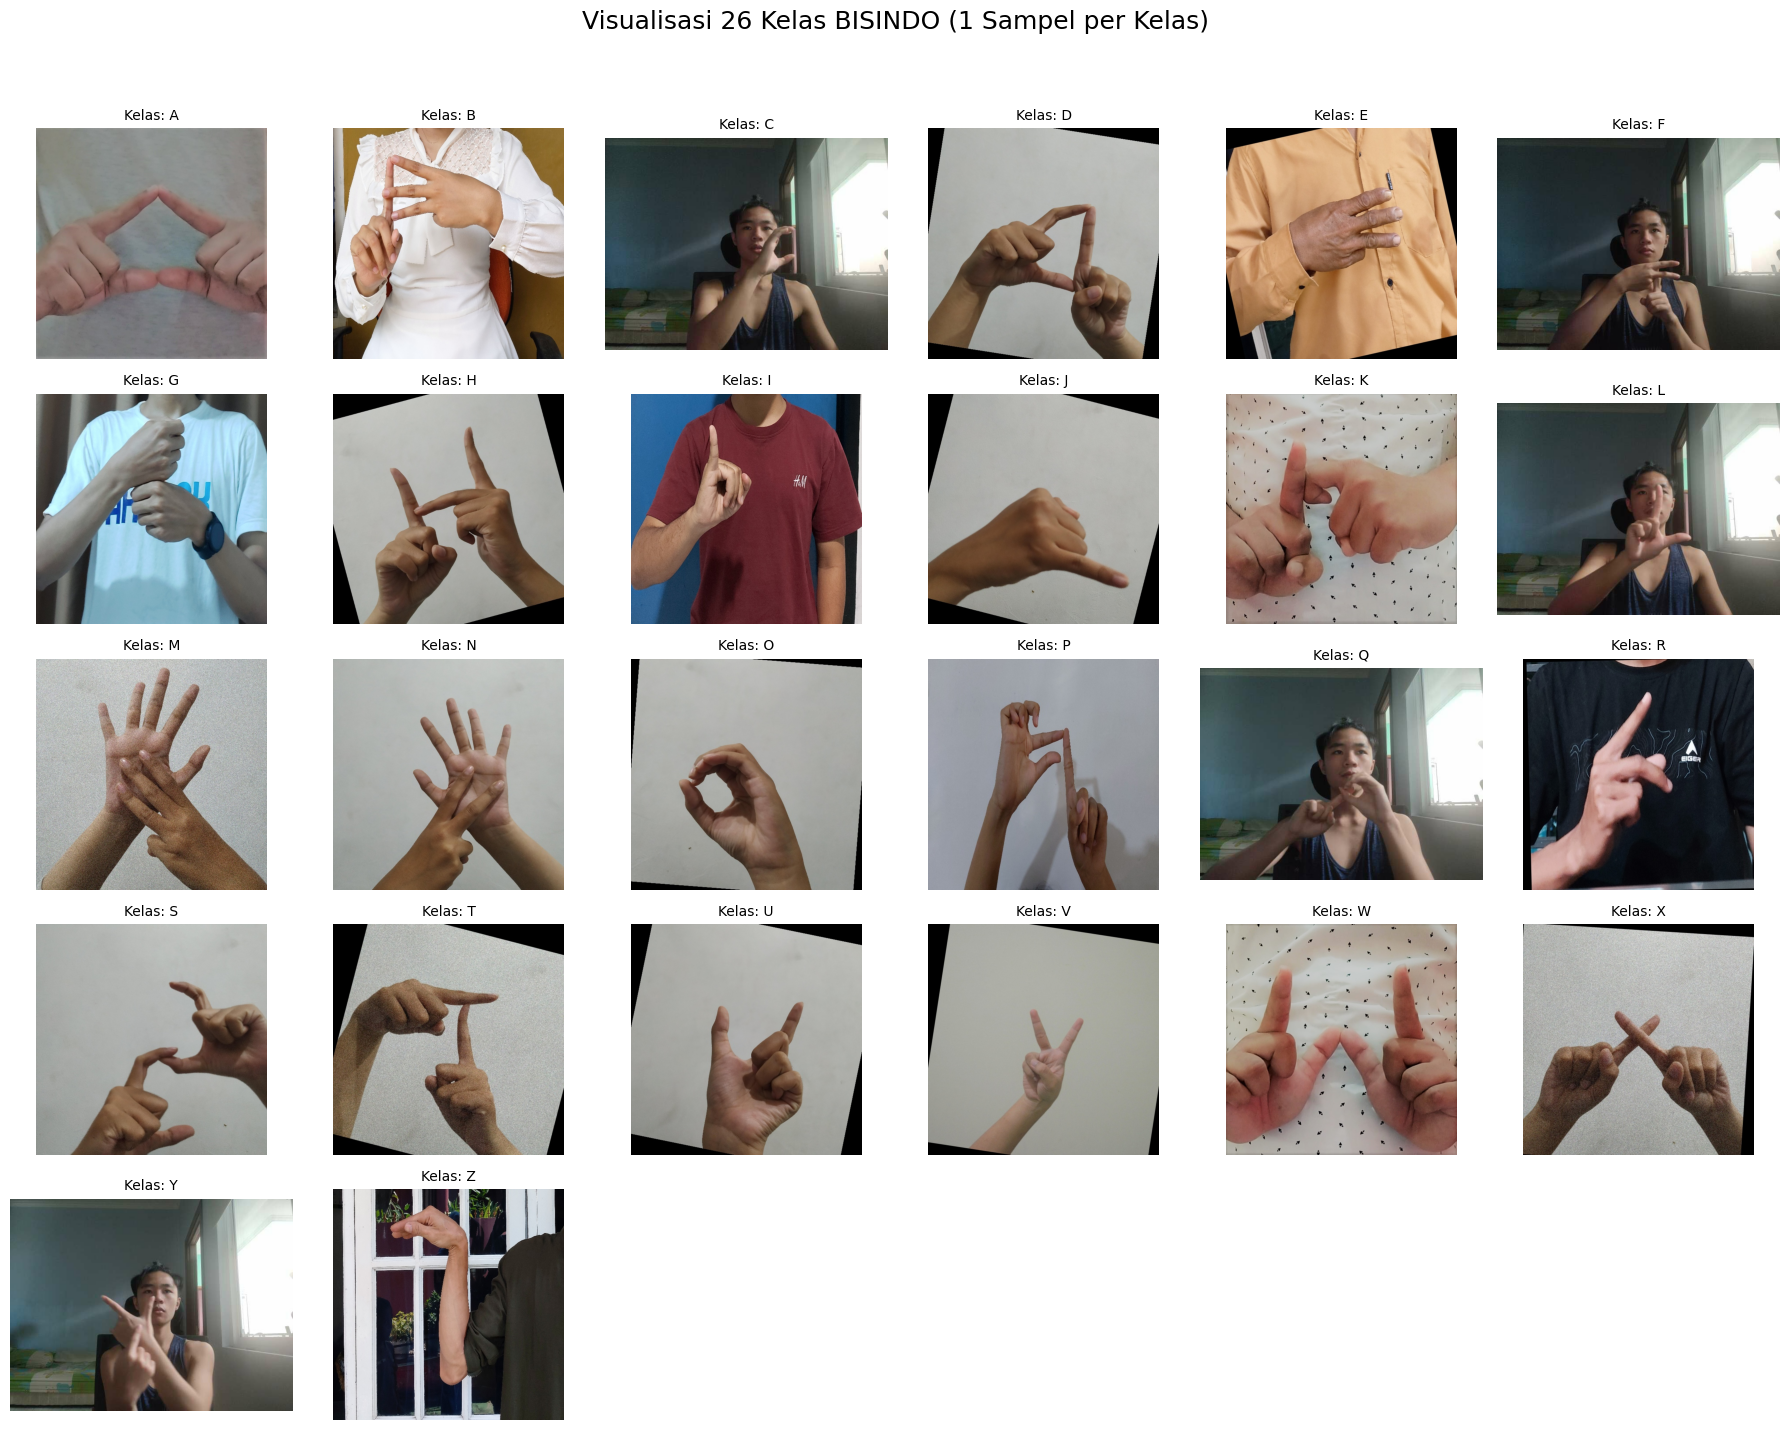

In [8]:
# Definisikan path dataset gabungan
DATASET_DIR = DATASET_COMBINED

# Cek apakah path-nya ada
if not os.path.exists(DATASET_DIR):
    print(f"ERROR: Path tidak ditemukan: {DATASET_DIR}")
else:
    print(f"Dataset gabungan ditemukan di: {DATASET_DIR}")
    all_folders = sorted([f for f in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, f))])
    print(f"Total folder (kelas): {len(all_folders)}")

    # Tentukan ukuran plot
    plt.figure(figsize=(18, 15))
    rows = 5
    cols = 6 # 5x6 = 30, cukup untuk 26 kelas

    print(f"Menampilkan 1 contoh gambar dari setiap kelas (total {len(all_folders)} kelas)...")

    for i, folder_name in enumerate(all_folders):
        if i >= rows * cols:
            break # Berhenti jika melebihi slot subplot

        folder_path = os.path.join(DATASET_DIR, folder_name)

        # Ambil 1 file gambar acak dari dalam folder
        try:
            all_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
            if not all_files:
                print(f"Folder {folder_name} kosong.")
                continue

            random_img_name = random.choice(all_files)
            img_path = os.path.join(folder_path, random_img_name)

            # Baca gambar menggunakan OpenCV
            img = cv2.imread(img_path)
            # Konversi BGR (OpenCV) ke RGB (Matplotlib)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Tampilkan di subplot
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img_rgb)
            plt.title(f"Kelas: {folder_name}", fontsize=10)
            plt.axis('off')

        except Exception as e:
            print(f"Error memproses folder {folder_name}: {e}")

    plt.suptitle("Visualisasi 26 Kelas BISINDO (1 Sampel per Kelas)", fontsize=18, y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

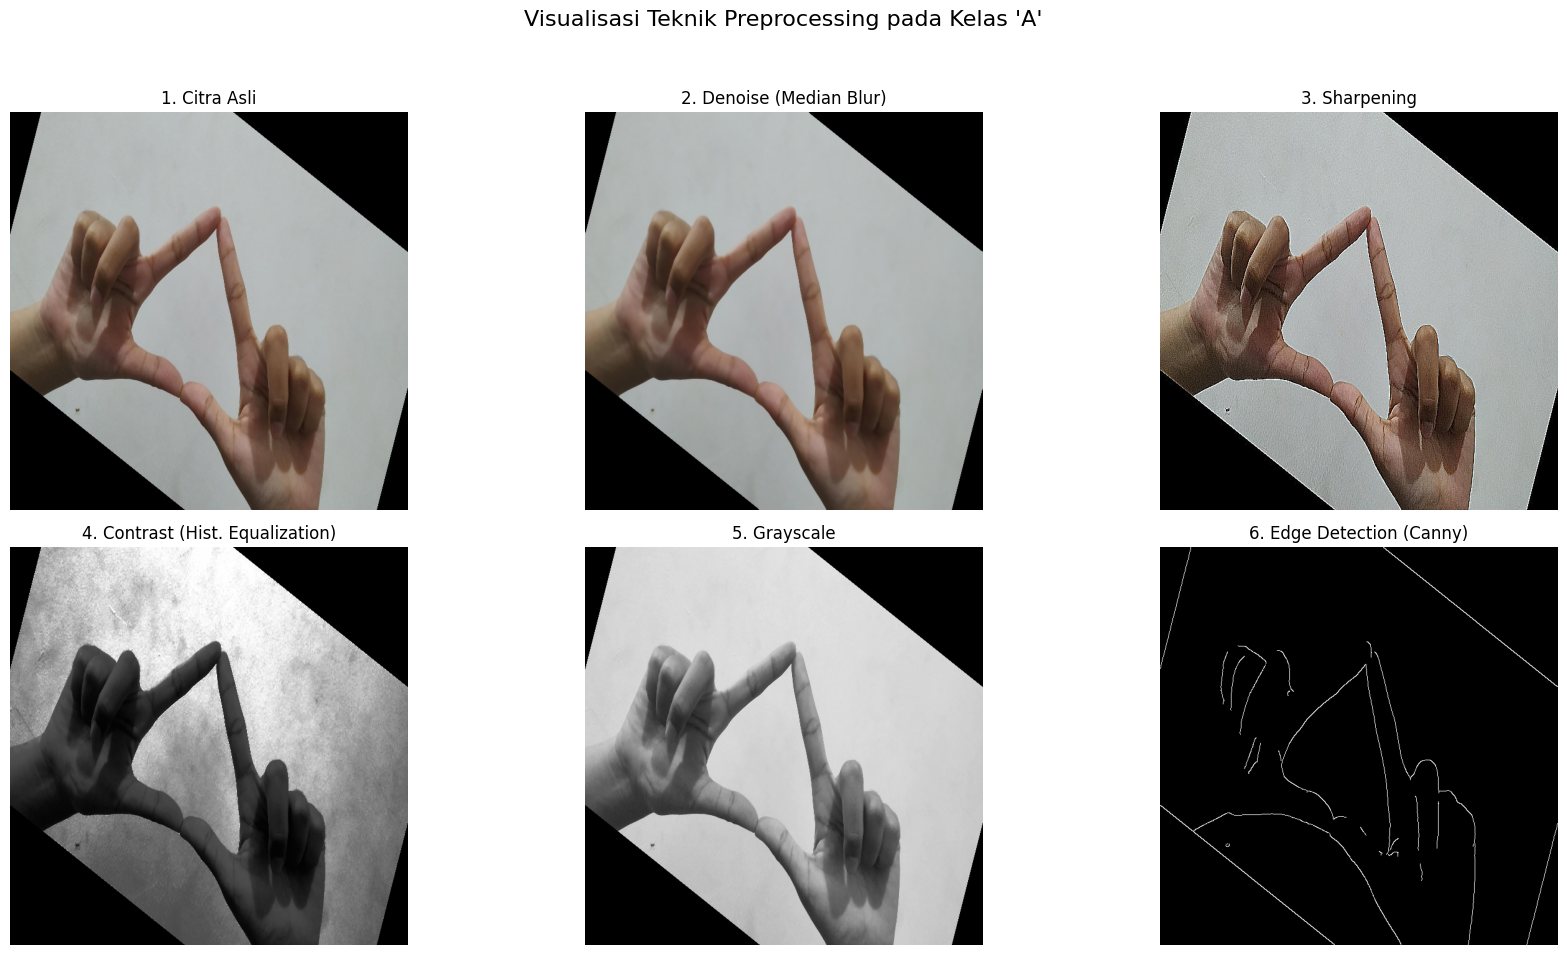

In [9]:
# Ambil contoh gambar untuk demonstrasi (Ambil gambar 'A' pertama)
sample_class = 'A'
sample_folder = os.path.join(DATASET_COMBINED, sample_class)
sample_file = random.choice(os.listdir(sample_folder))
sample_img_path = os.path.join(sample_folder, sample_file)

# Baca gambar
img_asli = cv2.imread(sample_img_path)
img_asli_rgb = cv2.cvtColor(img_asli, cv2.COLOR_BGR2RGB)

# --- 1. Denoising (Median Blur) ---
denoised = cv2.medianBlur(img_asli, 5) # Kernel 5x5
denoised_rgb = cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB)

# --- 2. Sharpening ---
kernel_sharpening = np.array([[-1, -1, -1],
                              [-1, 9, -1],
                              [-1, -1, -1]])
sharpened = cv2.filter2D(img_asli, -1, kernel_sharpening)
sharpened_rgb = cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB)

# --- 3. Contrast Enhancement (CLAHE) ---
gray = cv2.cvtColor(img_asli, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
contrast_enhanced = clahe.apply(gray)
# Konversi kembali ke BGR (untuk tampilan RGB)
clahe_rgb = cv2.cvtColor(cv2.equalizeHist(gray), cv2.COLOR_GRAY2RGB) # Menggunakan equalizeHist karena lebih sederhana

# --- 4. Edge Detection (Canny) ---
canny_edges = cv2.Canny(gray, 100, 200) # Threshold rendah: 100, tinggi: 200

# --- Visualisasi Hasil Preprocessing ---
plt.figure(figsize=(18, 10))
plt.suptitle(f"Visualisasi Teknik Preprocessing pada Kelas '{sample_class}'", fontsize=16)

plt.subplot(2, 3, 1)
plt.imshow(img_asli_rgb)
plt.title("1. Citra Asli")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(denoised_rgb)
plt.title("2. Denoise (Median Blur)")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(sharpened_rgb)
plt.title("3. Sharpening")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(clahe_rgb)
plt.title("4. Contrast (Hist. Equalization)")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(gray, cmap='gray')
plt.title("5. Grayscale")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(canny_edges, cmap='gray')
plt.title("6. Edge Detection (Canny)")
plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **MODELLING YOLO**

In [10]:
# Load model YOLOv8n-cls (nano classification)
model = YOLO('yolov8n-cls.pt')

print("Model YOLOv8 Classification berhasil dimuat.")

Model YOLOv8 Classification berhasil dimuat.


In [12]:
import os
import shutil
import random

# 1. Define SPLIT_OUTPUT_DIR
SPLIT_OUTPUT_DIR = '/content/dataset_combined_split'

# 2. Create the main SPLIT_OUTPUT_DIR and its subdirectories: 'train', 'val', and 'test'.
os.makedirs(SPLIT_OUTPUT_DIR, exist_ok=True)

train_dir = os.path.join(SPLIT_OUTPUT_DIR, 'train')
val_dir = os.path.join(SPLIT_OUTPUT_DIR, 'val')
test_dir = os.path.join(SPLIT_OUTPUT_DIR, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

print(f"Output directory for split data: {SPLIT_OUTPUT_DIR}")
print(f"Train directory created: {train_dir}")
print(f"Validation directory created: {val_dir}")
print(f"Test directory created: {test_dir}")

# Get all class folders from the combined dataset
class_names = sorted([d for d in os.listdir(DATASET_COMBINED) if os.path.isdir(os.path.join(DATASET_COMBINED, d))])

print(f"\nStarting manual data splitting for {len(class_names)} classes...")

for class_name in class_names:
    source_class_path = os.path.join(DATASET_COMBINED, class_name)

    # 3. Create corresponding subdirectories in SPLIT_OUTPUT_DIR/train, SPLIT_OUTPUT_DIR/val, and SPLIT_OUTPUT_DIR/test.
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # 4. Get a list of all image files within the current class folder
    all_images = [f for f in os.listdir(source_class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # 5. Randomly shuffle the list of image files
    random.shuffle(all_images)

    total_images = len(all_images)

    # 6. Calculate the number of images for each set
    train_split_idx = int(0.7 * total_images)
    val_split_idx = int(0.2 * total_images) + train_split_idx # Add train_split_idx to make it cumulative

    train_images = all_images[:train_split_idx]
    val_images = all_images[train_split_idx:val_split_idx]
    test_images = all_images[val_split_idx:]

    # 7. Copy the appropriate number of images to their respective directories
    for img_name in train_images:
        shutil.copy(os.path.join(source_class_path, img_name), os.path.join(train_dir, class_name, img_name))
    for img_name in val_images:
        shutil.copy(os.path.join(source_class_path, img_name), os.path.join(val_dir, class_name, img_name))
    for img_name in test_images:
        shutil.copy(os.path.join(source_class_path, img_name), os.path.join(test_dir, class_name, img_name))

    print(f"  Class '{class_name}': Train={len(train_images)}, Val={len(val_images)}, Test={len(test_images)}")

print("\n✅ Manual data splitting complete.")
print(f"Data split into: {SPLIT_OUTPUT_DIR}")

# Verify the structure and counts
print("\nVerifying split directories:")
print(f"Total classes in train: {len(os.listdir(train_dir))}")
print(f"Total classes in val: {len(os.listdir(val_dir))}")
print(f"Total classes in test: {len(os.listdir(test_dir))}")

Output directory for split data: /content/dataset_combined_split
Train directory created: /content/dataset_combined_split/train
Validation directory created: /content/dataset_combined_split/val
Test directory created: /content/dataset_combined_split/test

Starting manual data splitting for 26 classes...
  Class 'A': Train=84, Val=24, Test=12
  Class 'B': Train=84, Val=24, Test=12
  Class 'C': Train=82, Val=23, Test=13
  Class 'D': Train=83, Val=23, Test=13
  Class 'E': Train=84, Val=24, Test=13
  Class 'F': Train=85, Val=24, Test=13
  Class 'G': Train=85, Val=24, Test=13
  Class 'H': Train=83, Val=23, Test=13
  Class 'I': Train=85, Val=24, Test=13
  Class 'J': Train=85, Val=24, Test=13
  Class 'K': Train=83, Val=23, Test=13
  Class 'L': Train=85, Val=24, Test=13
  Class 'M': Train=84, Val=24, Test=13
  Class 'N': Train=84, Val=24, Test=12
  Class 'O': Train=85, Val=24, Test=13
  Class 'P': Train=85, Val=24, Test=13
  Class 'Q': Train=83, Val=23, Test=13
  Class 'R': Train=84, Val=24, T

In [13]:
results = model.train(
    data='/content/dataset_combined_split', # Folder utama yang berisi folder train/val/test
    epochs=30,                        # Jumlah epoch
    imgsz=128,                        # Ukuran gambar (sesuai setting awal Anda)
    name='bisindo_yolov8_GABUNGAN',   # Nama folder hasil training
    task='classify',
    device=0,                         # Gunakan GPU jika tersedia (device=0)
    optimizer='AdamW'                 # Menggunakan optimizer AdamW
)

print("\n✅ Proses Training Selesai.")

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_combined_split, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=128, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=bisindo_yolov8_GABUNGAN, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=

# **DATA EVALUATION AND TESTING**

In [14]:
# Lakukan validasi pada model terbaik yang dihasilkan
best_model_path = os.path.join(results.save_dir, 'weights', 'best.pt')
best_model = YOLO(best_model_path)

metrics = best_model.val()

print("\n--- Metrik Validasi ---")
print(f"Top 1 Accuracy: {metrics.top1:.4f}")
print(f"Top 5 Accuracy: {metrics.top5:.4f}")

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,468,186 parameters, 0 gradients, 3.3 GFLOPs
train: /content/dataset_combined_split/train... found 2848 images in 26 classes ✅ 
val: /content/dataset_combined_split/val... found 1119 images in 26 classes ✅ 
test: /content/dataset_combined_split/test... found 620 images in 26 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1142.4±472.1 MB/s, size: 40.5 KB)
val: Scanning /content/dataset_combined_split/val... 1119 images, 0 corrupt: 100% ━━━━━━━━━━━━ 1119/1119 456.4Kit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 70/70 6.9it/s 10.1s
                   all       0.99          1
Speed: 0.0ms preprocess, 0.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val

--- Metrik Validasi ---
Top 1 Accuracy: 0.9902
Top 5 Accuracy: 1.0000


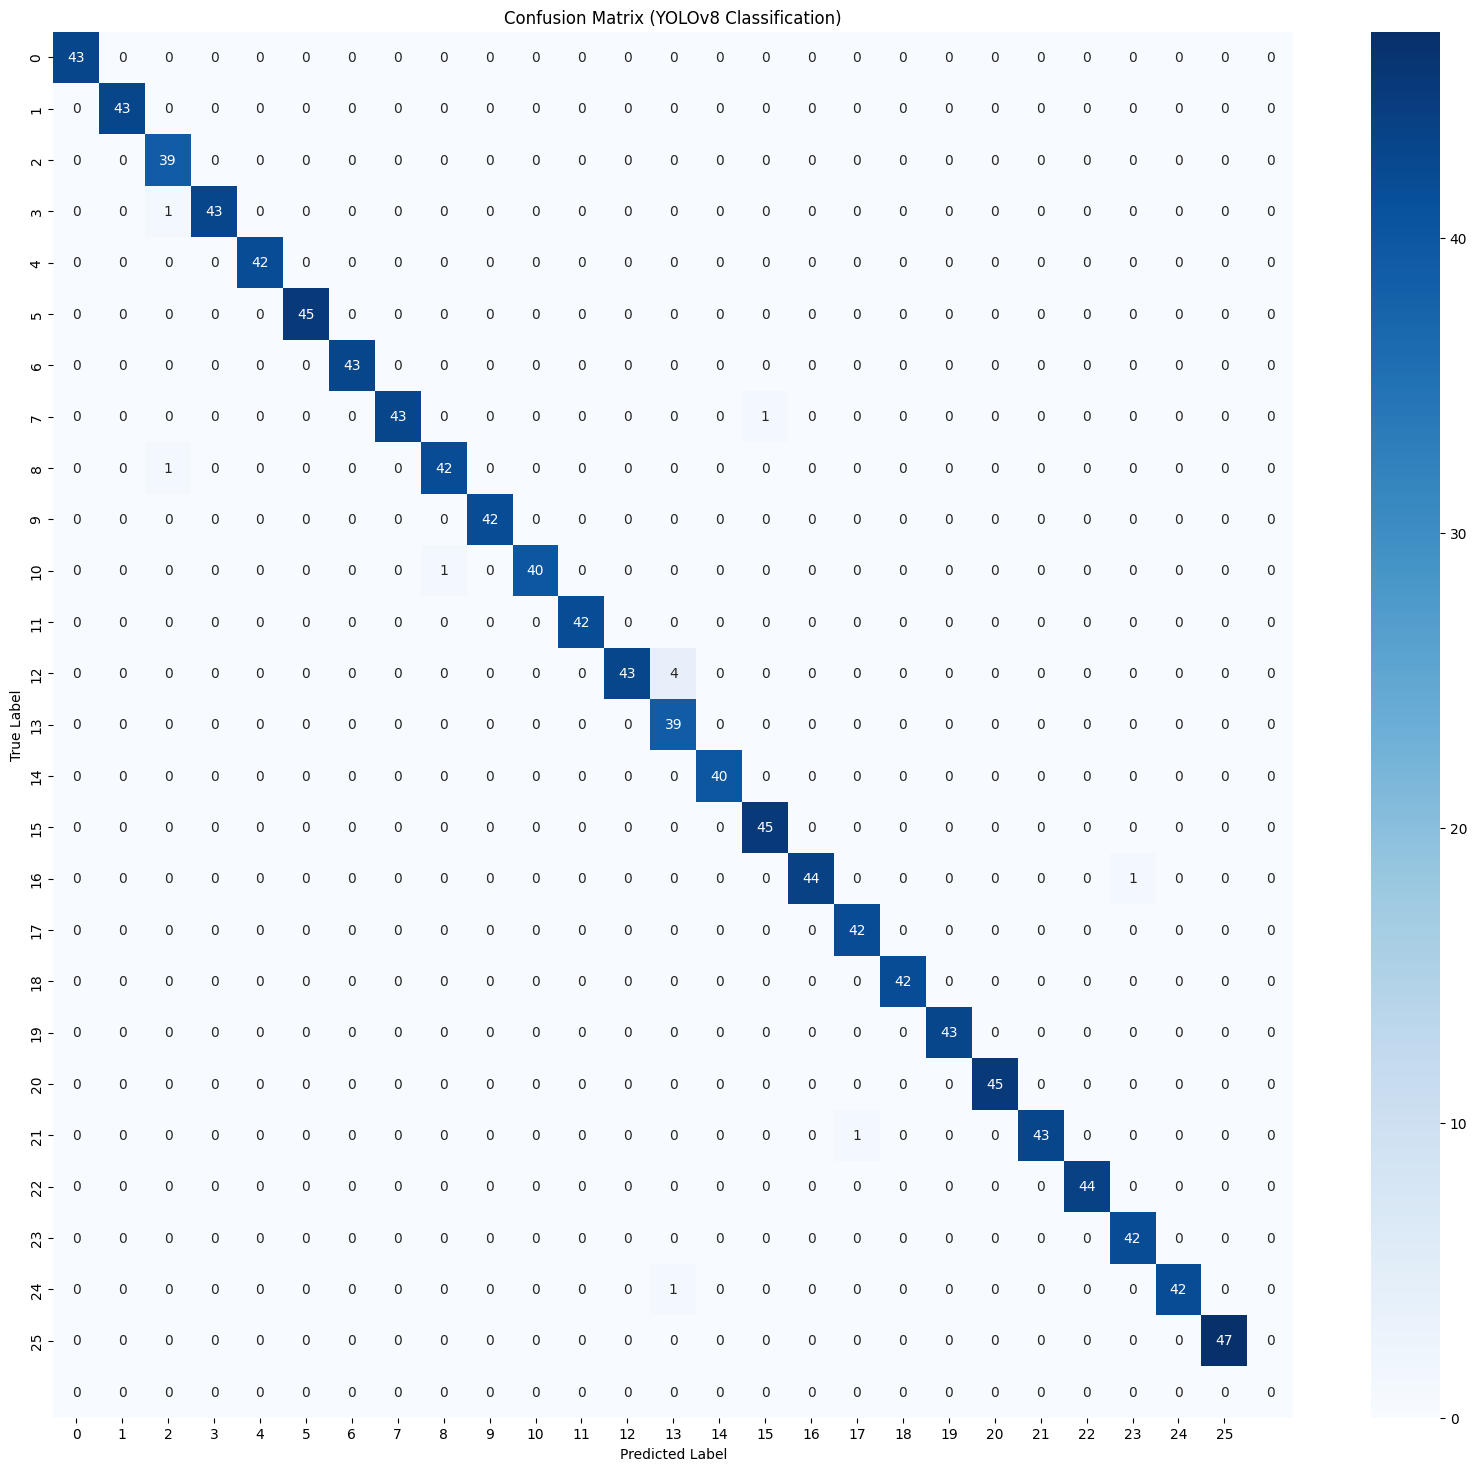


--- Metrik Per Kelas (Precision, Recall, F1-Score) ---
Class | Precision  | Recall     | F1-Score  
A     | 1.0000     | 1.0000     | 1.0000    
B     | 1.0000     | 1.0000     | 1.0000    
C     | 0.9512     | 1.0000     | 0.9750    
D     | 1.0000     | 0.9773     | 0.9885    
E     | 1.0000     | 1.0000     | 1.0000    
F     | 1.0000     | 1.0000     | 1.0000    
G     | 1.0000     | 1.0000     | 1.0000    
H     | 1.0000     | 0.9773     | 0.9885    
I     | 0.9767     | 0.9767     | 0.9767    
J     | 1.0000     | 1.0000     | 1.0000    
K     | 1.0000     | 0.9756     | 0.9877    
L     | 1.0000     | 1.0000     | 1.0000    
M     | 1.0000     | 0.9149     | 0.9556    
N     | 0.8864     | 1.0000     | 0.9398    
O     | 1.0000     | 1.0000     | 1.0000    
P     | 0.9783     | 1.0000     | 0.9890    
Q     | 1.0000     | 0.9778     | 0.9888    
R     | 0.9767     | 1.0000     | 0.9882    
S     | 1.0000     | 1.0000     | 1.0000    
T     | 1.0000     | 1.0000     | 1.0000    

In [15]:
import torch # Import the torch library

# --- 1. Plot Confusion Matrix (CM) ---

# The metrics object 'metrics' is of type ClassifyMetrics
# It already contains the calculated confusion matrix.
# We can access the confusion matrix directly from it.
cm_matrix = metrics.confusion_matrix.matrix
class_names = best_model.names           # Nama kelas

# Note: y_true and y_pred are implicitly represented in cm_matrix
# For calculating per-class metrics, we directly use cm_matrix

# Tampilkan Confusion Matrix
plt.figure(figsize=(20, 18))
sns.heatmap(
    cm_matrix,
    annot=True,
    fmt='.0f', # Changed from 'd' to '.0f' to handle potential float conversion during annotation
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (YOLOv8 Classification)')
plt.show()

# --- 2. Tampilkan Metrik Precision, Recall, F1-Score Per Kelas ---

print("\n--- Metrik Per Kelas (Precision, Recall, F1-Score) ---")
print(f"{'Class':<5} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
print("="*41)

for i in range(len(class_names)):
    # Hitung True Positive (TP), False Positive (FP), False Negative (FN)
    TP = cm_matrix[i, i]
    FP = cm_matrix[:, i].sum() - TP
    FN = cm_matrix[i, :].sum() - TP

    # Hitung Metriks
    precision = TP / (TP + FP + 1e-6) # Tambahkan epsilon untuk menghindari pembagian nol
    recall = TP / (TP + FN + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6);

    # Tampilkan
    class_name = class_names[i]
    print(f"{class_name:<5} | {precision:<10.4f} | {recall:<10.4f} | {f1_score:<10.4f}")

In [17]:
# Pastikan semua import yang diperlukan sudah ada dari sel-sel sebelumnya
import os
import shutil
import zipfile
import io
from google.colab import drive, files
from IPython.display import display, Javascript, HTML, clear_output
from base64 import b64decode
from PIL import Image
import numpy as np
import cv2

# Data & Komputasi
import random

# Deep Learning (YOLOv8)
from ultralytics import YOLO

# =========================================================
# BAGIAN 1: FUNGSI UPLOAD GAMBAR (Definisi)
# =========================================================

def upload_image():
    """Memungkinkan pengguna mengunggah gambar dan mengembalikan path file yang disimpan."""
    print("Silakan unggah file gambar Anda.")
    uploaded = files.upload()

    if uploaded:
        for fn in uploaded.keys():
            print(f'User uploaded file "{fn}" ({len(uploaded[fn])} bytes)')
            # Save the uploaded file to a temporary location
            with open(fn, 'wb') as f:
                f.write(uploaded[fn])
            print(f"✅ Gambar berhasil diunggah dan disimpan sebagai: {fn}")
            return fn
    else:
        print("❌ Tidak ada file yang diunggah.")
        return None

# =========================================================
# BAGIAN 2: EKSEKUSI PREDIKSI DARI UPLOAD GAMBAR
# =========================================================

print("--- Memulai Proses Prediksi dengan Unggah Gambar ---")
test_img_path = upload_image()

# =========================================================
# BAGIAN 3: PREDIKSI MENGGUNAKAN MODEL
# =========================================================

# Pastikan 'best_model' dimuat sebelum digunakan
# Ini akan memuat model terbaik yang disimpan dari training sebelumnya
if 'best_model' not in locals():
    try:
        best_model_path = os.path.join('/content/runs/classify/bisindo_yolov8_GABUNGAN', 'weights', 'best.pt')
        best_model = YOLO(best_model_path)
        print("Model 'best_model' berhasil dimuat kembali.")
    except Exception as e:
        print(f"❌ Error memuat 'best_model': {e}")
        best_model = None


if test_img_path and best_model is not None:
    print("\n--- Memulai Prediksi ---")

    prediction_results = best_model.predict(
        source=test_img_path,
        imgsz=128,
        save=True,
        conf=0.25 # Confidence threshold
    )

    # Dapatkan hasil prediksi Top-1 dan Top-5
    probs = prediction_results[0].probs

    # Asumsi 'class_names' sudah tersedia di model
    # Mengakses label dari best_model.names menggunakan indeks dari probs
    top1_label = best_model.names[probs.top1]
    top1_conf = probs.top1conf.item()
    top5_labels = [best_model.names[idx] for idx in probs.top5]

    print("\n--- HASIL PREDIKSI ---")
    print(f"Gambar Sumber: {test_img_path}")
    print(f"Kelas Prediksi Top-1: {top1_label}")
    print(f"Probabilitas Top-1: {top1_conf:.4f}")
    print(f"Kelas Prediksi Top-5: {top5_labels}")

    # Tampilkan lokasi gambar hasil prediksi
    print(f"\nHasil visualisasi prediksi disimpan di: {prediction_results[0].save_dir}")

else:
    print("\n❌ Error: Objek 'best_model' belum didefinisikan atau gagal menangkap/mengunggah gambar.")


--- Memulai Proses Prediksi dengan Unggah Gambar ---
Silakan unggah file gambar Anda.


Saving Screenshot 2025-12-03 225512.png to Screenshot 2025-12-03 225512.png
User uploaded file "Screenshot 2025-12-03 225512.png" (8122 bytes)
✅ Gambar berhasil diunggah dan disimpan sebagai: Screenshot 2025-12-03 225512.png

--- Memulai Prediksi ---

image 1/1 /content/Screenshot 2025-12-03 225512.png: 128x128 O 0.99, J 0.01, I 0.00, Z 0.00, Q 0.00, 9.2ms
Speed: 3.8ms preprocess, 9.2ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)
Results saved to /content/runs/classify/predict

--- HASIL PREDIKSI ---
Gambar Sumber: Screenshot 2025-12-03 225512.png
Kelas Prediksi Top-1: O
Probabilitas Top-1: 0.9890
Kelas Prediksi Top-5: ['O', 'J', 'I', 'Z', 'Q']

Hasil visualisasi prediksi disimpan di: /content/runs/classify/predict


In [18]:
# Export model terbaik ke format yang berbeda (misalnya ONNX, TFLite, SavedModel)
export_results = best_model.export(
    format='tflite',             # Format: onnx, torchscript, tflite, saved_model
    imgsz=128,
    int8=False                   # Set True untuk post-training quantization (TFLite)
)

print("\n✅ Export Model Selesai.")
print(f"Model tersimpan sebagai: {export_results}")

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/runs/classify/bisindo_yolov8_GABUNGAN/weights/best.pt' with input shape (1, 3, 128, 128) BCHW and output shape(s) (1, 26) (2.9 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'ai-edge-litert>=1.2.0', 'onnx>=1.12.0,<=1.19.1', 'onnx2tf>=1.26.3', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 20 packages in 5.69s
Prepared 11 packages in 8.19s
Installed 11 packages in 282ms
 + ai-edge-litert==2.0.3
 + backports-strenum==1.3.1
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.19.1
 + onnx-graphsurgeon==0.5.8
 + onnx2tf==1.28.6
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.79
 + sng4onnx==1